#  Predicting Anime Ratings in MLlib

In [3]:
# locate spark without needing to set ENV variables
import findspark
findspark.init('C:/Users/Max.Polaczuk/Documents/Downloads/spark-2.1.1-bin-hadoop2.7/spark-2.1.1-bin-hadoop2.7')

# spark imports
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as seas

sc = SparkContext() # start the spark context
spark = SparkSession(sc) # start spark session


In [4]:
# import the data - use pandas, then convert to spark dataframe after preprocessing
dat = pd.read_csv('anime.csv')

# remove "nan" data
dat = dat.dropna().reset_index(drop=True)

# lets see what this looks like:
dat.head(5)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


C:\Users\Max.Polaczuk\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


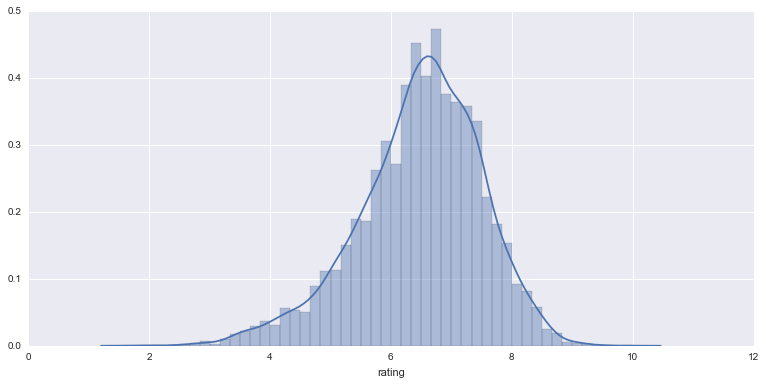

In [5]:
%matplotlib inline
import math
## Ratings look like this:
ratings = dat[dat['rating'].apply(lambda x: math.isnan(x) == False)]['rating']

# graphing
seas.set(rc={"figure.figsize": (13, 6)})
seas.distplot(ratings)

### Preprocessing in Pandas

In [89]:
### Preprocessing
N = len(dat) # number of samples

### get all the genres:
genres = []  # store all genres here:
for i in range(N):
    # split the string into array
    tmp = str(dat['genre'][i]).split()
    for j in range(len(tmp)):
        if tmp[j].replace(',','') != genres:
            # add new genre to the list
            genres.append(tmp[j].replace(',',''))
# sort the array & show
genres = np.sort(np.unique(genres))
print(genres)

#create a lookup table to refer to later:
gn_lut = {g: i for i,g in enumerate(genres)}

### get all of the episode names
types = np.unique(dat['type'].tolist()).tolist()
print(types)
# lookup table
typ_lut = {t: i for i,t in enumerate(types)}

### for each sample encode their values in matrices
a_genre = np.zeros((N,len(genres)))
a_type = np.zeros((N,len(types)))

for i in range(N):
    # get the genre first:
    tmp = str(dat['genre'][i]).split()
    for j in range(len(tmp)):
        a_genre[i,gn_lut[tmp[j].replace(',','')]] = 1. 
    # get the type:
    a_type[i,typ_lut[str(dat['type'][i])]] = 1.

### send back to pd dataframe:
newdat = pd.DataFrame(a_genre)
newdat = pd.concat((dat.ix[:,[1,4,5,6]],newdat,pd.DataFrame(a_type)),axis = 1)

# rename columns:
newdat.columns = ['name','episodes','rating','members'] + [i for i in range(np.shape(newdat)[1]-4)]
newdat = newdat.dropna().reset_index(drop=True)
# remove where episodes is not a digit
newdat = newdat[newdat['episodes'].apply(lambda x: str(x).isdigit())].reset_index(drop=True)
newdat['episodes'] = [float(i) for i in newdat['episodes']] # convert episodes to floating data
newdat.head(5)

['Action' 'Adventure' 'Ai' 'Arts' 'Cars' 'Comedy' 'Dementia' 'Demons'
 'Drama' 'Ecchi' 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror'
 'Josei' 'Kids' 'Life' 'Magic' 'Martial' 'Mecha' 'Military' 'Music'
 'Mystery' 'Parody' 'Police' 'Power' 'Psychological' 'Romance' 'Samurai'
 'School' 'Sci-Fi' 'Seinen' 'Shoujo' 'Shounen' 'Slice' 'Space' 'Sports'
 'Super' 'Supernatural' 'Thriller' 'Vampire' 'Yaoi' 'Yuri' 'of']
['Movie', 'Music', 'ONA', 'OVA', 'Special', 'TV']


,name,episodes,rating,members,0,1,2,3,4,5,...,42,43,44,45,46,47,48,49,50,51
0,Kimi no Na wa.,1.0,9.37,200630,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Fullmetal Alchemist: Brotherhood,64.0,9.26,793665,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Gintama°,51.0,9.25,114262,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Steins;Gate,24.0,9.17,673572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Gintama&#039;,51.0,9.16,151266,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Convert to spark

In [92]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

anime = spark.createDataFrame(newdat)
print(anime.take(1))

# rename "rating" to be "label" because that is what we are after
anime = anime.withColumnRenamed("rating", "label")

# show some statistics about the label
anime.describe('label').show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|             11830|
|   mean| 6.484608622147075|
| stddev|1.0191474981344986|
|    min|              1.67|
|    max|              10.0|
+-------+------------------+



### The Model
We use a Random Forest Regression to predict the anime's rating

In [93]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import RandomForestRegressor

# split data to test and training sets:
test, train = anime.randomSplit([0.3,0.7])

## start the model pipeline
ignore = ['name', 'label']

assembler = VectorAssembler(
    inputCols=[x for x in anime.columns if x not in ignore],
    outputCol='features')

# transform the data into feature vector
assembler.transform(train)

# build model
rf = RandomForestRegressor(featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf])

# train model
model = pipeline.fit(train)


['episodes', 'members', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51']


In [94]:
# show the top 20 predictions
from pyspark.sql.functions import asc, desc # for sorting dataframe
model.transform(test).select('name','prediction','label').sort(desc('prediction')).show()

+--------------------+------------------+-----+
|                name|        prediction|label|
+--------------------+------------------+-----+
|Hajime no Ippo: N...| 7.901716933131214| 8.75|
|  Shingeki no Kyojin| 7.820336618430128| 8.54|
|Great Teacher Oni...| 7.812821901282921| 8.77|
| Fullmetal Alchemist|7.7990370453750995| 8.33|
|        Eureka Seven| 7.769850973669928| 8.19|
|Clannad: After Story| 7.769850973669928| 9.06|
|             Monster| 7.758017568590384| 8.72|
|Tsubasa Chronicle...| 7.745589642267262|  7.7|
|              Naruto| 7.731277404807878| 7.81|
|          Death Note|7.7227976177137805| 8.71|
|Phantom: Requiem ...| 7.716538410290643| 8.16|
|     Hunter x Hunter| 7.709451089018404| 8.48|
|Hunter x Hunter (...| 7.709451089018404| 9.13|
|          D.Gray-man| 7.709451089018404|  8.2|
|Katekyo Hitman Re...| 7.709451089018404| 8.37|
|  Mawaru Penguindrum| 7.709253941076028| 8.08|
|        Kuroshitsuji| 7.709231506514968| 8.06|
|      Pandora Hearts|7.7027841229395975

In [126]:
from difflib import get_close_matches

## find animes and predict from an ad hoc query...
def predict_anime(an_name):
    namz = anime.select('name').toPandas().ix[:,0].tolist() # list of anime names from spark
    try:
        ani = get_close_matches(an_name,namz,1)[0] # gets the closest anime
        print('Anime selected is:',ani)
    except:
        print('No matches for anime name!')
        return 'no matches'
        
    # if all good then return the dataframe
    tstdat = anime.filter(anime['name'] == ani)
    # run prediction
    return model.transform(tstdat).select('name','prediction','label').show()


### Do some predictions for a given anime query

Some animes are using their japanese names so it doesn't always detect.

Lets first do some good animes:

In [130]:
predict_anime('shokugeki no soma')

Anime selected is: Shokugeki no Souma
+------------------+------------------+-----+
|              name|        prediction|label|
+------------------+------------------+-----+
|Shokugeki no Souma|7.6286600058329865| 8.61|
+------------------+------------------+-----+



In [132]:
predict_anime('dragonball z')

Anime selected is: Dragon Ball Z
+-------------+-----------------+-----+
|         name|       prediction|label|
+-------------+-----------------+-----+
|Dragon Ball Z|7.731277404807878| 8.32|
+-------------+-----------------+-----+



In [134]:
predict_anime('kimi no wa')

Anime selected is: Kimi no Na wa.
+--------------+-----------------+-----+
|          name|       prediction|label|
+--------------+-----------------+-----+
|Kimi no Na wa.|7.398889606125907| 9.37|
+--------------+-----------------+-----+



And now try with some bad animes:

In [137]:
predict_anime('hametsu no mars')

Anime selected is: Hametsu no Mars
+---------------+-----------------+-----+
|           name|       prediction|label|
+---------------+-----------------+-----+
|Hametsu no Mars|6.954753780455791| 2.37|
+---------------+-----------------+-----+



In [140]:
predict_anime('hundred')

Anime selected is: Hundred
+-------+-----------------+-----+
|   name|       prediction|label|
+-------+-----------------+-----+
|Hundred|7.156872473293802| 6.53|
+-------+-----------------+-----+



Ratings are pretty flat predictions, I think the model needs to change - including hyperparam changes